In [50]:
import re
import seaborn as sns
import threading
from tqdm import tqdm
import torch

from dataclasses import dataclass, fields, asdict
from model.model import PageAccModel

In [51]:
@dataclass
class Page:
    buffer: int
    is_local_temp: int
    fork_num: int
    block_num: int
    mode: int
    relam: int
    relfilenode: int
    relhasindex: int
    relpersistence: int
    relkind: int
    relnatts: int
    relfrozenxid: int
    relminmxid: int
    hit: int

In [52]:
with open("train_data/acc_logfile2", "r") as file:
    data = file.read()

pattern = r"buffer={(\d+)} is_local_temp={(\w+)} fork_num={(\w+)} block_num={(\d+)} mode={(\w+)} strategy={} relam={(\d+)} relfilenode={(\d+)} relhasindex={(\w+)} relpersistence={(\w+)} relkind={(\w+)} relnatts={(\d+)} relfrozenxid={(\d+)} relminmxid={(\d+)} hit={(\w+)}"
matches = re.findall(pattern, data)

pages = []

for match in matches:
    buffer = int(match[0])
    is_local_temp = 1 if match[1] == "true" else 0
    fork_num = ["MAIN_FORKNUM", "FSM_FORKNUM", "VISIBILITYMAP_FORKNUM", "INIT_FORKNUM"].index(match[2])
    block_num = int(match[3])
    mode = ["RBM_NORMAL", "RBM_ZERO_AND_LOCK", "RBM_ZERO_AND_CLEANUP_LOCK", "RBM_ZERO_ON_ERROR", "RBM_NORMAL_NO_LOG"].index(match[4])
    relam = int(match[5])
    relfilenode = int(match[6])
    relhasindex = 1 if match[7] == "true" else 0
    relpersistence = ["p", "u", "t"].index(match[8])
    relkind = ["r", "i", "S", "t", "v", "m", "c", "f", "p", "I"].index(match[9])
    relnatts = int(match[10])
    relfrozenxid = int(match[11])
    relminmxid = int(match[12])
    hit = 1 if match[13] == "true" else 0

    page = Page(
        buffer,
        is_local_temp, 
        fork_num,
        block_num,
        mode,
        relam,
        relfilenode,
        relhasindex,
        relpersistence,
        relkind,
        relnatts,
        relfrozenxid,
        relminmxid,
        hit,
    )
    pages.append(page)

In [53]:
with open("train_data/acc_logfile2_pages", "w") as f:
    for page in pages:
        f.write(f"{page.buffer}\n")


In [54]:
print(len(pages))

1024067


In [55]:
# evict page with last access
def find_optimal_victim(page_access_ar, buf, current_index):
    #MAX_RATE = 10000
    evict_ind = 0
    evict_rate = 0

    # mutex = threading.Lock()

    def check_items_rate(start, stop):
        nonlocal evict_ind
        nonlocal evict_rate

        for i in range(start, stop):
            rate = 0
            for page in page_access_ar[current_index:]:
                rate += 1
                if page == buf[i]:
                    break
            
            # with mutex:
            if rate > evict_rate:
                evict_rate = rate
                evict_ind = i
    
    check_items_rate(0, len(buf))
    # threads = []
    # threads_count = 16
    # step = len(buf) // threads_count
    # for i in range(threads_count):
    #     start = i * step
    #     stop = len(buf) if i == threads_count - 1 else (i + 1) * step
    #     check_items_rate(start, stop)
    #     # thread = threading.Thread(target=lambda: check_items_rate(start, stop))
    #     # threads.append(thread)
    #     # thread.start()

    # for thread in threads:
    #     thread.join()
    
    return evict_ind
 
def find_optimal_hit_rate(page_access_ar, buf_size):
    buf = []
    hit = 0
    # for i, page in tqdm(enumerate(page_access_ar)):
    for i in tqdm(range(len(page_access_ar))):
        page = page_access_ar[i]
        if page in buf:
            hit += 1
            continue

        if len(buf) < buf_size:
            buf.append(page)
        else:
            evict_ind = find_optimal_victim(page_access_ar, buf, i)
            buf[evict_ind] = page
    
    return hit / len(page_access_ar)

In [61]:
optimal_results = []
with open("train_data/acc_logfile2_victims", "r") as f:
    for line in f:
        optimal_results.append(int(line))

In [91]:
TRAIN_SIZE = len(pages)
BATCH_SIZE = 2048
BUFFER_SIZE = 32

In [89]:
TRAIN_SIZE

1024067

In [58]:
sum([page.hit for page in pages[:TRAIN_SIZE]]) / TRAIN_SIZE

0.6318912727389907

In [63]:
# find_optimal_hit_rate([page.buffer for page in pages[:TRAIN_SIZE]], BUFFER_SIZE)
sum([1 if victim < BUFFER_SIZE else 0 for victim in optimal_results[:TRAIN_SIZE]]) / TRAIN_SIZE

0.3155281832145748

<Axes: ylabel='Count'>

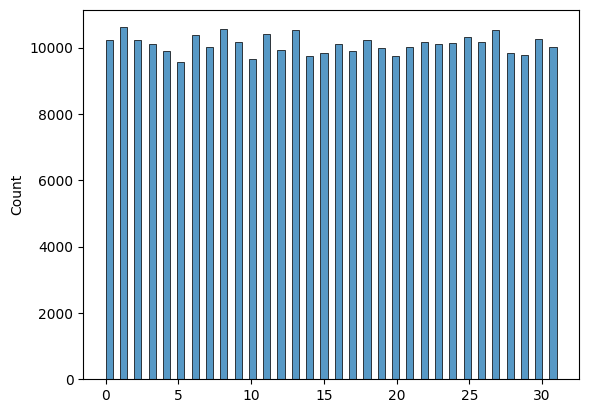

In [64]:
sns.histplot([victim for victim in optimal_results[:TRAIN_SIZE] if victim < BUFFER_SIZE])

In [86]:
def get_model_optimal_res(pages, buffer, current_index):
    res = [0] * (len(buffer) + 1)
    if (current_index >= len(pages)):
        print(f"ERROR: current_index=={current_index} pages.size() == {len(pages)}")

    already_in_buf = any(buf.buffer == pages[current_index].buffer for buf in buffer)
    if already_in_buf:
        res[-1] = 1
        return res, -1
    
    empty_pages = [index for index, value in enumerate(buffer) if value.buffer == -1]
    if len(empty_pages) > 0:
        for i in empty_pages:
            res[i] = 1 / len(empty_pages)
        
        return res, empty_pages[0]
    
    #victim = find_optimal_victim(pages, [page.buffer for page in buffer], current_index)
    victim = optimal_results[current_index]
    res[victim] = 1

    return res, victim

In [97]:
def get_train_data(pages, buffer, batch_start, batch_end):
    pages_acc = torch.Tensor([list(asdict(page).values()) for page in pages[batch_start:batch_end]])

    buffers = []
    optimal_predictions = []

    for i in range(batch_start, batch_end):
        if i == TRAIN_SIZE:
            print(f"STRANGE: i=={i} bathc_end=={batch_end}")

        buffers.append([value for obj in buffer for value in asdict(obj).values()])

        res, victim = get_model_optimal_res(pages, buffer, i)
        optimal_predictions.append(res)

        if victim >= 0:
            if victim == BUFFER_SIZE:
                print(f"ERROR: {victim} {batch_start} {batch_end} {i}")
            buffer[victim] = pages[i]
    
    return pages_acc, torch.Tensor(buffers), torch.Tensor(optimal_predictions), buffer


In [99]:
model = PageAccModel(len(fields(Page)), 32, BUFFER_SIZE)

In [100]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

h, c = None, None

model.train()
for epoch in range(5):
    buffer = [Page(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)] * BUFFER_SIZE
    loss_sum = 0
    pbar = tqdm(range(0, TRAIN_SIZE, BATCH_SIZE))
    for i in pbar:
        batch_start = i
        # batch_end = i + BATCH_SIZE if i + BATCH_SIZE < TRAIN_SIZE else TRAIN_SIZE
        batch_end = i + BATCH_SIZE
        if batch_end >= TRAIN_SIZE:
            continue
        pages_acc, buffers, optimal_predictions, buffer = get_train_data(pages, buffer, batch_start, batch_end)
    
        optimizer.zero_grad()
    
        out, h, c = model.forward(pages_acc, buffers, h, c)
        # print(out)
    
        loss_value = loss(out, optimal_predictions)
    
        loss_value.backward()
        optimizer.step()
    
        h = h.detach()
        c = c.detach()

        loss_sum += loss_value.item()
        loss_avg = loss_sum / (batch_end // BATCH_SIZE)

        pbar.set_postfix_str(f"loss={loss_avg}")

100%|██████████| 501/501 [07:44<00:00,  1.08it/s, loss=2.8628083786964416]
